In [1]:
%load_ext autoreload
%config Completer.use_jedi = False

In [2]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt


# Topology optimization for the fundamental frequency of a vibrating structure

## 1. Example problem definition

In [3]:
mesh = FEMOL.mesh.rectangle_Q4(20, 20, 15, 15)

problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plate')
material1 = FEMOL.materials.isotropic_bending_benchmark()
problem.define_materials(material1)
problem.define_tensors(1)  # thick=1

problem.add_fixed_domain(FEMOL.domains.inside_box([0, 20], [[0, 20]]), ddls=[2, 4])
problem.add_fixed_domain(FEMOL.domains.inside_box([[0, 20]], [0, 20]), ddls=[2, 3])

problem.add_forces(force=[0, 0, -1, 0, 0, 0], domain=FEMOL.domains.inside_box([[9,11]], [[9,11]]))

problem.assemble('K')
problem.assemble('M')

w, v = problem.solve(filtre=1)
reference_vector = v[0]  # Save for MAC Analysis

solving using scipy
solved in :  1.8448398113250732  s


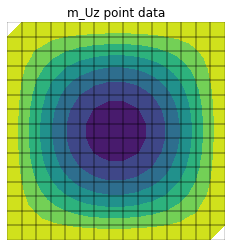

In [4]:
mesh.add_mode('m', v[0], 6)
mesh.plot.point_data('m_Uz')

## 2. The optimization problem formulation

### Optimization problem constraints

maximize : $\; min\; (\omega_j^2) \;\; j = 1,...,J $

with : $\; \rho_1, ..., \rho_{N_E}$ The individual element densities of the problem

and : $j = 1,...,J$ The vibration modes of the structure

Subject to :

The eigenvalue theorem : 

$ K \phi_j = \omega_j^2 M \phi_j \; \; j = 1, ..., J$

The orthogonality criteria :

$ \phi_j^T M \phi_k = \delta_{jk}, \; \; j \geq k, \;\; kj = 1,...,J$

Where : $\delta_{jk} = 1$ if $i=k$ and $0$ if $j \neq k$

The Volume constraint :

$\sum_{e=1}^{N_e} \; \rho_e V_e - V^* \leq 0$ and $V^* = \alpha V_0$

Where : $\alpha$ is the volume fraction constraint and $V_0$ is the domain volume

And the admissible density values :

$0 < \rho_{min} \leq \rho_e \leq 1$ for $e = 1, ..., N_e$

Here, $\rho_{min}$ represents the admissible lower bound to the element density (typically $10^{-3}$)

### Sensitivity Analysis

The sensibility of the eigenvalue is given by $\frac{\partial \lambda_j}{\partial \rho_e}$ where $\lambda_j = \omega_j^2$ is obtained by differentiating the eigenvalue theorem with respect to $\rho_e$ :



In [ ]:
# Computing desing variable sensitivity
!python 

Python 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> 

In [37]:
3*15

45

solving with scipy


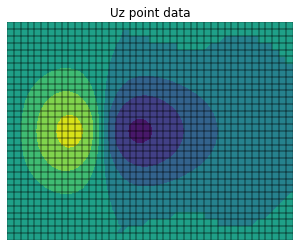

In [57]:
import FEMOL

# Mesh
nelx = 42 # elements in the x direction
nely = 32 # elements in the y direction
Lx = nelx
Ly = nely
mesh = FEMOL.mesh.rectangle_Q4(Lx, Ly, nelx, nely)

# FEM Problem
problem = FEMOL.FEM_Problem('displacement', 'plate', mesh)

# Define the composite material layups and materials
flax_base = FEMOL.materials.general_flax()
layup_base = FEMOL.laminate.Layup(flax_base, plies=[0, 90, 0, 90])
carbon_coating = FEMOL.materials.general_carbon()
layup_coating = FEMOL.laminate.Layup(carbon_coating, plies=[0, -45, 90, 45], h_core=10)
problem.define_materials(flax_base, carbon_coating)
problem.define_tensors(layup_base, layup_coating)

# Fix the guitar boundary
problem.add_fixed_domain(FEMOL.domains.guitar_domain(Lx=Lx, Ly=Ly), ddls=[0, 1, 2])

# define the string tension
force_domain = FEMOL.domains.inside_box([Lx/3], [[8*Ly/20, 12*Ly/20]])
force = [0, 0, 0, -1e4, 0, 0]
problem.add_forces(force, force_domain)

mesh = problem.solve()
mesh.plot.point_data('Uz', wrapped=True)

In [58]:
def guitar_sides(Lx, Ly):
    angle = np.pi / 6
    p = angle / (np.pi / 2)
    x1 = 2 * Ly / 6 + 2 * Ly / 6 * np.sin(angle)
    y1 = 2 * Ly / 6 - 2 * Ly / 6 * np.cos(angle)
    x2 = Lx - Ly / 4 - Ly / 4 * np.sin(angle)
    y2 = 2 * Ly / 6 - Ly / 4 * np.cos(angle)
    a, b, c, d = FEMOL.domains.create_polynomial(x1, y1, x2, y2, p)

    def sides(x, y):
        Y_val = a * x ** 3 + b * x ** 2 + c * x + d
        return ~((x > x1) & (x < x2) & (y > Y_val) & (y < -Y_val + Ly))

    return sides

In [59]:
# Part where no material can be added
# Outside domain
circle1 = FEMOL.domains.outside_circle((2*Ly/6), (2*Ly/6), (2*Ly/6))
circle2 = FEMOL.domains.outside_circle((2*Ly/6), (4*Ly/6), (2*Ly/6))
circle3 = FEMOL.domains.outside_circle((Lx-Ly/4) , 2*Ly/6, Ly/4)
circle4 = FEMOL.domains.outside_circle((Lx-Ly/4) , 4*Ly/6, Ly/4)
box1 = FEMOL.domains.outside_box(0, Lx, 2*Ly/6, 4*Ly/6)
sides = guitar_sides(Lx, Ly)
sound_hole = FEMOL.domains.inside_circle(2*Lx/3, Ly/2, Ly/7)

def voided_guitar(x, y):
    """
    Parts where there is no material on the guitar
    """
    if np.array([circle1(x,y), circle2(x,y), circle3(x,y), circle4(x,y), box1(x,y), sides(x, y)]).all():
        return True
    elif sound_hole(x,y):
        return True
    else:
        return False 


KeyboardInterrupt: 

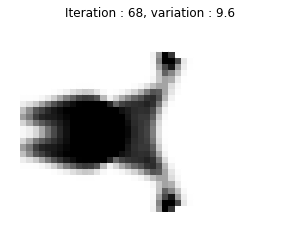

In [60]:
topo_problem = FEMOL.TOPOPT_Problem(problem, volfrac=0.2, penal=3)
topo_problem.void_domain = voided_guitar
mesh = topo_problem.solve(plot=True)

In [70]:
mesh.points[:, 0] -=1

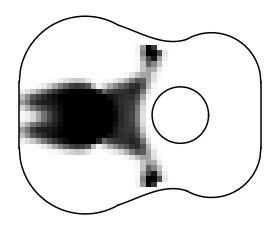

In [74]:
FEMOL.utils.guitar_outline(Lx+2, Ly+4)
mesh.plot.cell_data('X68', )
plt.gcf().savefig('guit_topo', dpi=300)

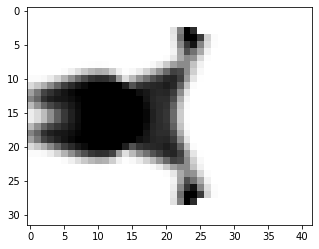

In [81]:
X = mesh.cell_data['X68']['quad'].reshape(42, 32)
X1 = np.rot90(X)
plt.imshow(X1, cmap='binary')

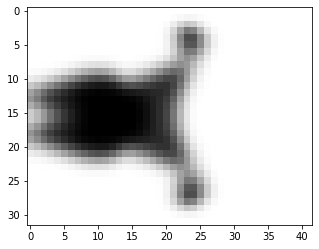

In [90]:
import scipy.ndimage
X2 = scipy.ndimage.gaussian_filter(X1, sigma=1)
plt.imshow(X2, cmap='binary')

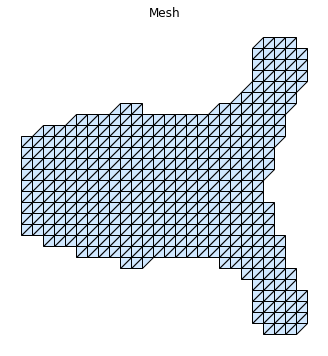

In [121]:
new_mesh = FEMOL.mesh.rectangle_Q4(Lx-1, Ly-1, Lx-1, Ly-1)
points = np.vstack([new_mesh.points.T, X2.reshape(-1)*10, ])
points = points.T
new_cells = []
for cell in new_mesh.plot.all_tris:
    if (points[cell][:,2] > 1).all():
        new_cells.append(cell)
cell_dict = {'triangle': np.array(new_cells)}
mesh2 = FEMOL.Mesh(points, cell_dict)
mesh2.display()


In [125]:
import meshio
import pyvista
#pyvista.set_jupyter_backend('pythreejs')

cells = [('triangle', mesh2.plot.all_tris)]
points[:, 2] = points[:, 2]-3
mesh3 = meshio.Mesh(points, cells)
mesh3.write('guit_topo.vtk')
pv_mesh = pyvista.read('guit_topo.vtk')
pv_mesh.plot()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

In [126]:
mesh3.write('guit_topo.stl')

In [99]:
X.reshape(-1).shape

(1344,)